In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Mon Jan 22 02:44:30 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   44C    P0    47W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [4]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [5]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = -2
hp.const_sigma = False
hp.quantize = False
hp.prior_mu = 0.99

In [6]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [7]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_uniform_-2/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 9473, model_list, optimizer_list)

total 0


### Dataset

In [8]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [9]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [10]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [11]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

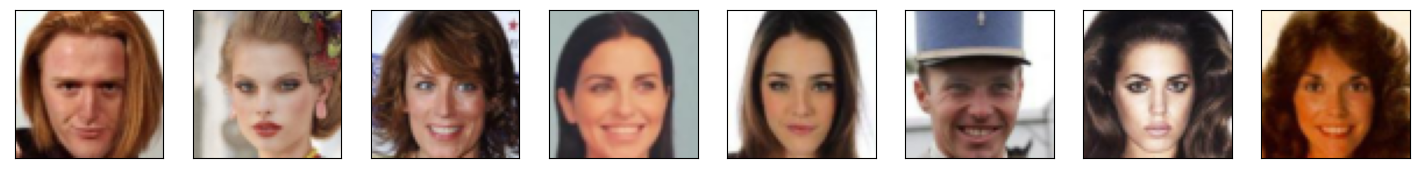

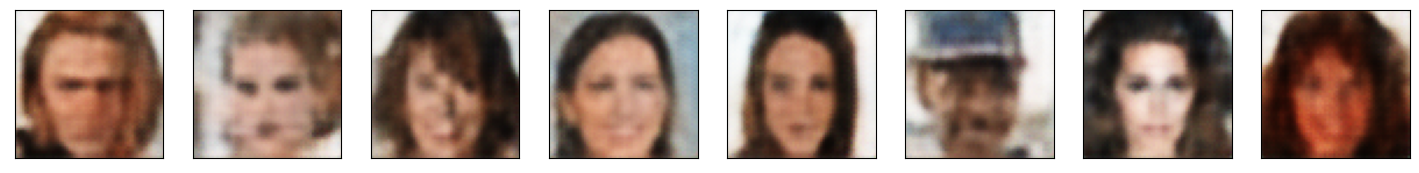

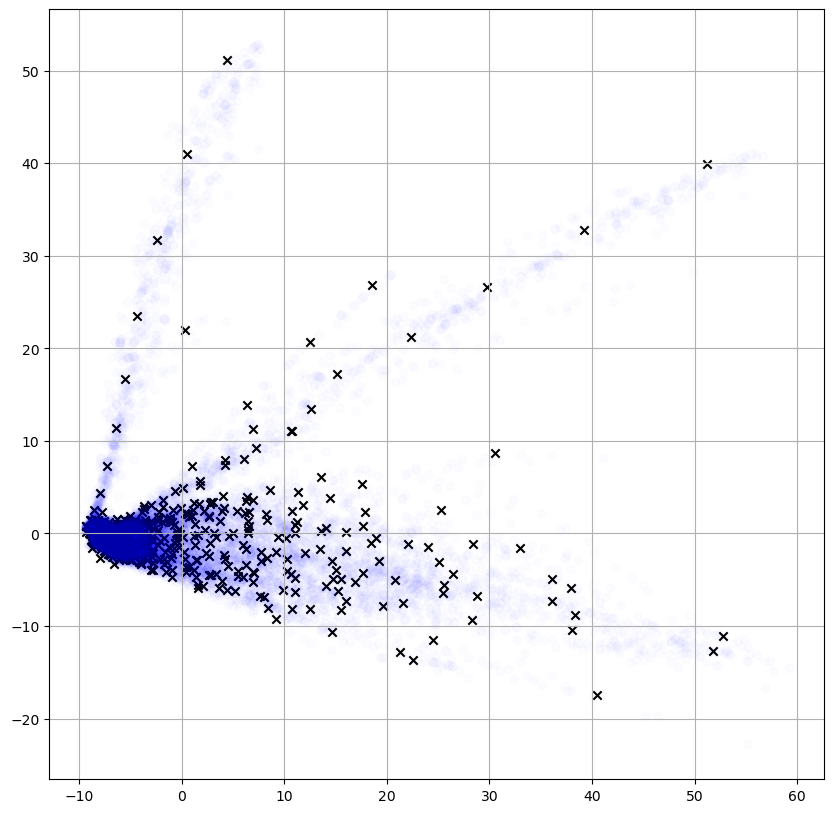

3001
lse_loss -96.13003540039062
commit_loss 0.09631504118442535
recon_loss 0.006018184125423431
3002
lse_loss -95.19583892822266
commit_loss 0.10688230395317078
recon_loss 0.006076425313949585
3003
lse_loss -96.25354766845703
commit_loss 0.10359644889831543
recon_loss 0.006318175699561834
3004
lse_loss -95.89359283447266
commit_loss 0.09769203513860703
recon_loss 0.0062335580587387085
3005
lse_loss -95.68563842773438
commit_loss 0.10041815042495728
recon_loss 0.006395383737981319
3006
lse_loss -97.13443756103516
commit_loss 0.10333888232707977
recon_loss 0.006067550741136074
3007
lse_loss -96.88697052001953
commit_loss 0.10891082137823105
recon_loss 0.0062421755865216255
3008
lse_loss -98.68228912353516
commit_loss 0.1014363020658493
recon_loss 0.006569645833224058
3009
lse_loss -96.59182739257812
commit_loss 0.10020638257265091
recon_loss 0.0065496256574988365
3010
lse_loss -93.99882507324219
commit_loss 0.10975851118564606
recon_loss 0.006535543128848076
3011
lse_loss -97.3379364013

3086
lse_loss -98.63062286376953
commit_loss 0.09321741759777069
recon_loss 0.005914468318223953
3087
lse_loss -98.9366226196289
commit_loss 0.09809722006320953
recon_loss 0.005553448107093573
3088
lse_loss -100.97492980957031
commit_loss 0.09700802713632584
recon_loss 0.005926147103309631
3089
lse_loss -99.94212341308594
commit_loss 0.11216925084590912
recon_loss 0.005848955363035202
3090
lse_loss -100.66887664794922
commit_loss 0.1038917824625969
recon_loss 0.005287767853587866
3091
lse_loss -100.05155181884766
commit_loss 0.1033489778637886
recon_loss 0.00628350954502821
3092
lse_loss -98.52117919921875
commit_loss 0.10055992007255554
recon_loss 0.0056848069652915
3093
lse_loss -99.43902587890625
commit_loss 0.1006108745932579
recon_loss 0.006345848552882671
3094
lse_loss -100.18360137939453
commit_loss 0.09587637335062027
recon_loss 0.0054785385727882385
3095
lse_loss -100.39781951904297
commit_loss 0.09853588044643402
recon_loss 0.006573464721441269
3096
lse_loss -95.6696319580078

3171
lse_loss -103.58810424804688
commit_loss 0.09204836934804916
recon_loss 0.006100590340793133
3172
lse_loss -102.09820556640625
commit_loss 0.11209676414728165
recon_loss 0.006303711794316769
3173
lse_loss -102.81973266601562
commit_loss 0.09020934253931046
recon_loss 0.0060338219627738
3174
lse_loss -104.89142608642578
commit_loss 0.0904311090707779
recon_loss 0.0061377547681331635
3175
lse_loss -103.54834747314453
commit_loss 0.09925834834575653
recon_loss 0.006031887140125036
3176
lse_loss -103.28092956542969
commit_loss 0.09358600527048111
recon_loss 0.005905881058424711
3177
lse_loss -100.24208068847656
commit_loss 0.11373692750930786
recon_loss 0.005930159240961075
3178
lse_loss -104.63247680664062
commit_loss 0.09207460284233093
recon_loss 0.005972824990749359
3179
lse_loss -104.05265808105469
commit_loss 0.09492892771959305
recon_loss 0.005715946666896343
3180
lse_loss -102.43153381347656
commit_loss 0.09423840790987015
recon_loss 0.006076366640627384
3181
lse_loss -101.278

lse_loss -105.2830581665039
commit_loss 0.08907845616340637
recon_loss 0.005617448594421148
3256
lse_loss -105.39695739746094
commit_loss 0.09399636089801788
recon_loss 0.005914757959544659
3257
lse_loss -103.90682983398438
commit_loss 0.08803033828735352
recon_loss 0.005897530820220709
3258
lse_loss -105.33671569824219
commit_loss 0.09758223593235016
recon_loss 0.006216345354914665
3259
lse_loss -107.92595672607422
commit_loss 0.08548501878976822
recon_loss 0.005509498529136181
3260
lse_loss -102.73755645751953
commit_loss 0.09749886393547058
recon_loss 0.0060179876163601875
3261
lse_loss -105.88501739501953
commit_loss 0.08764376491308212
recon_loss 0.005584308411926031
3262
lse_loss -106.24237060546875
commit_loss 0.08648699522018433
recon_loss 0.005650912411510944
3263
lse_loss -106.1680679321289
commit_loss 0.09124139696359634
recon_loss 0.005584891885519028
3264
lse_loss -104.21105194091797
commit_loss 0.09650768339633942
recon_loss 0.005957610905170441
3265
lse_loss -101.0152053

3341
lse_loss -107.57398223876953
commit_loss 0.09664042294025421
recon_loss 0.005282271653413773
3342
lse_loss -106.8234634399414
commit_loss 0.09189514070749283
recon_loss 0.007018262054771185
3343
lse_loss -107.09754943847656
commit_loss 0.09028691053390503
recon_loss 0.005915701389312744
3344
lse_loss -104.10403442382812
commit_loss 0.0911802127957344
recon_loss 0.006641808897256851
3345
lse_loss -106.06665802001953
commit_loss 0.09395899623632431
recon_loss 0.005805200897157192
3346
lse_loss -106.94318389892578
commit_loss 0.08391940593719482
recon_loss 0.0054834699258208275
3347
lse_loss -103.6559829711914
commit_loss 0.10554365813732147
recon_loss 0.0055251470766961575
3348
lse_loss -107.42635345458984
commit_loss 0.08447396755218506
recon_loss 0.006259067915380001
3349
lse_loss -102.91790771484375
commit_loss 0.12115395814180374
recon_loss 0.006102295126765966
3350
lse_loss -106.10161590576172
commit_loss 0.08787575364112854
recon_loss 0.007011560257524252
3351
lse_loss -107.73

3426
lse_loss -108.62349700927734
commit_loss 0.09244555979967117
recon_loss 0.006034068297594786
3427
lse_loss -109.20130157470703
commit_loss 0.08831418305635452
recon_loss 0.005972252693027258
3428
lse_loss -110.90950012207031
commit_loss 0.09098462760448456
recon_loss 0.006312709301710129
3429
lse_loss -109.34326934814453
commit_loss 0.09461242705583572
recon_loss 0.006273362785577774
3430
lse_loss -110.28044891357422
commit_loss 0.08168406784534454
recon_loss 0.005569337867200375
3431
lse_loss -110.10272979736328
commit_loss 0.09348320215940475
recon_loss 0.006313392426818609
3432
lse_loss -111.0837173461914
commit_loss 0.08660835027694702
recon_loss 0.005643456242978573
3433
lse_loss -109.06734466552734
commit_loss 0.08395979553461075
recon_loss 0.00709904171526432
3434
lse_loss -109.52605438232422
commit_loss 0.0957876592874527
recon_loss 0.005812437739223242
3435
lse_loss -110.6080093383789
commit_loss 0.09220553189516068
recon_loss 0.005869566462934017
3436
lse_loss -104.83338

lse_loss -110.1426010131836
commit_loss 0.08955837786197662
recon_loss 0.006205366924405098
3511
lse_loss -111.95443725585938
commit_loss 0.1037483662366867
recon_loss 0.006161001976579428
3512
lse_loss -108.95459747314453
commit_loss 0.09487882256507874
recon_loss 0.0074519021436572075
3513
lse_loss -111.42903900146484
commit_loss 0.08306355774402618
recon_loss 0.006399291567504406
3514
lse_loss -111.23566436767578
commit_loss 0.08285032212734222
recon_loss 0.005934016313403845
3515
lse_loss -112.16030883789062
commit_loss 0.08763375133275986
recon_loss 0.005814659874886274
3516
lse_loss -108.49520111083984
commit_loss 0.0943048894405365
recon_loss 0.006026002578437328
3517
lse_loss -109.41776275634766
commit_loss 0.08321928232908249
recon_loss 0.007197253406047821
3518
lse_loss -112.9059829711914
commit_loss 0.07976765930652618
recon_loss 0.006062999367713928
3519
lse_loss -111.21965789794922
commit_loss 0.08663622289896011
recon_loss 0.006353860720992088
3520
lse_loss -113.836158752

lse_loss -113.72551727294922
commit_loss 0.08212542533874512
recon_loss 0.0068358625285327435
3596
lse_loss -115.73271942138672
commit_loss 0.07710052281618118
recon_loss 0.006093633361160755
3597
lse_loss -115.5634765625
commit_loss 0.0792219340801239
recon_loss 0.005600192584097385
3598
lse_loss -114.57077026367188
commit_loss 0.08082911372184753
recon_loss 0.005918510258197784
3599
lse_loss -115.60054779052734
commit_loss 0.08230017125606537
recon_loss 0.006067249923944473
3600
lse_loss -115.3693618774414
commit_loss 0.08412249386310577
recon_loss 0.006408341228961945
3601
lse_loss -113.89743041992188
commit_loss 0.08690530061721802
recon_loss 0.006437499076128006
3602
lse_loss -111.31800079345703
commit_loss 0.1156596839427948
recon_loss 0.006399174686521292
3603
lse_loss -111.52217864990234
commit_loss 0.11820024251937866
recon_loss 0.00619891844689846
3604
lse_loss -114.20182800292969
commit_loss 0.08168362081050873
recon_loss 0.0069783274084329605
3605
lse_loss -114.353950500488

3682
lse_loss -116.18090057373047
commit_loss 0.08138473331928253
recon_loss 0.006274338811635971
3683
lse_loss -114.0464096069336
commit_loss 0.08646588027477264
recon_loss 0.006101972423493862
3684
lse_loss -116.22702026367188
commit_loss 0.08101771771907806
recon_loss 0.005782413762062788
3685
lse_loss -114.72724914550781
commit_loss 0.07987382262945175
recon_loss 0.006146916188299656
3686
lse_loss -116.9888916015625
commit_loss 0.087552011013031
recon_loss 0.006452028639614582
3687
lse_loss -115.27313232421875
commit_loss 0.08676033467054367
recon_loss 0.005633661523461342
3688
lse_loss -115.6407699584961
commit_loss 0.08581225574016571
recon_loss 0.0067574395798146725
3689
lse_loss -115.29560089111328
commit_loss 0.08982981741428375
recon_loss 0.005809161812067032
3690
lse_loss -114.868896484375
commit_loss 0.08146608620882034
recon_loss 0.006256002001464367
3691
lse_loss -118.0595474243164
commit_loss 0.08052925765514374
recon_loss 0.005728186573833227
3692
lse_loss -117.07511138

3766
lse_loss -117.1205825805664
commit_loss 0.0794614925980568
recon_loss 0.0060305348597466946
3767
lse_loss -116.94043731689453
commit_loss 0.08642983436584473
recon_loss 0.006196044385433197
3768
lse_loss -119.03307342529297
commit_loss 0.07927493751049042
recon_loss 0.006405680440366268
3769
lse_loss -118.15438079833984
commit_loss 0.07851265370845795
recon_loss 0.006177217699587345
3770
lse_loss -118.60184478759766
commit_loss 0.07512232661247253
recon_loss 0.005295505281537771
3771
lse_loss -117.1839599609375
commit_loss 0.08318956941366196
recon_loss 0.006224568001925945
3772
lse_loss -119.13069915771484
commit_loss 0.07900595664978027
recon_loss 0.006041345652192831
3773
lse_loss -119.4488754272461
commit_loss 0.08457712829113007
recon_loss 0.005844011902809143
3774
lse_loss -118.33295440673828
commit_loss 0.080739825963974
recon_loss 0.005895609967410564
3775
lse_loss -117.1202392578125
commit_loss 0.08466954529285431
recon_loss 0.006484615616500378
3776
lse_loss -119.5163803

3851
lse_loss -119.39957427978516
commit_loss 0.08202232420444489
recon_loss 0.007258707657456398
3852
lse_loss -120.0682144165039
commit_loss 0.07690010219812393
recon_loss 0.006280037574470043
3853
lse_loss -118.44396209716797
commit_loss 0.07913162559270859
recon_loss 0.005787569098174572
3854
lse_loss -119.5303726196289
commit_loss 0.08016111701726913
recon_loss 0.006180759519338608
3855
lse_loss -118.73921966552734
commit_loss 0.07598123699426651
recon_loss 0.006048776209354401
3856
lse_loss -119.17801666259766
commit_loss 0.07551802694797516
recon_loss 0.0060806660912930965
3857
lse_loss -119.28678131103516
commit_loss 0.07829368114471436
recon_loss 0.00574199203401804
3858
lse_loss -120.66509246826172
commit_loss 0.07323871552944183
recon_loss 0.006876887287944555
3859
lse_loss -119.64864349365234
commit_loss 0.0808122456073761
recon_loss 0.006501137278974056
3860
lse_loss -119.17144012451172
commit_loss 0.08150782436132431
recon_loss 0.0065867225639522076
3861
lse_loss -119.425

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')